# Notebook for Gmail Spam Filter Using LLM

In this example, we will show you how to use LLM to filter your spam gmails via uniflow.



<div style="border-left: 4px solid lightblue; background-color: lightblue; color: white; padding: 10px 20px; margin: 20px 0;">

### Before running the code

1. You will need to set up the `uniflow` conda environment to run this notebook by following this [instruction](https://github.com/CambioML/uniflow/tree/main#installation).

2. You will need a valid api key to run the code (either OpenAI or Google Gemini):
    - [Get Google API key](https://ai.google.dev/tutorials/setup). 
    - [Get OpenAI API key](https://platform.openai.com/api-keys). 
 
    Once you have the key, set it as the environment variable (either `OPENAI_API_KEY` or `GOOGLE_API_KEY`) within a `.env` file in the root directory of this repository. For more details, see this [instruction](https://github.com/CambioML/uniflow/tree/main#api-keys).

</div>

### Import the libraries and update system path

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import pprint

sys.path.append(".")
sys.path.append("..")
sys.path.append("../..")


Install the dependencies

In [ ]:
# !pip install -q tiktoken
# !pip install -q --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [5]:
from uniflow import Context
from uniflow.flow.client import ExtractClient
from uniflow.flow.config import ExtractGmailConfig
from uniflow.viz import Viz
from uniflow.flow.flow_factory import FlowFactory
from uniflow.flow.client import TransformClient
from uniflow.flow.config  import TransformGmailSpamConfig
from uniflow.op.model.model_config  import GoogleModelConfig, OpenAIModelConfig

from dotenv import load_dotenv
load_dotenv()


/Users/goldpiggy/anaconda3/envs/0227/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

### Initialize an `ExtractClient` with `ExtractGmailConfig`

There are two steps to build an Gmail spam filter: extract the email content and then classify whether it's spam. Let's start with the extract step.

<div style="border-left: 4px solid lightblue; background-color: lightblue; color: white; padding: 10px 20px; margin: 20px 0;">

### Set credentials

You will need to setup and download `credentials.json` following google workspace [instructions](https://developers.google.com/gmail/api/quickstart/python). (May take 5-10 minutes.)

</div>


With the credentials, you can initialize an `ExtractClient` to extract your email text.

In [ ]:
extract_client = ExtractClient(
    ExtractGmailConfig(
        credentials_path="credentials.json",
        token_path="token.json",
        )
    )

Once run the above cell, there will be a pop up URL to authorize the Gmail log in from your own gmail spam filter. 

Click `Allow`:

<p align="center">
  <img src="./gmail-spam-filter-login.png" alt="Alternate Text" width="50%" />
</p>


Now use the `extract_client` to extract the latest unread email body and snippet (maximum 10 emails). Estimated running time: 10-20 seconds.

In [9]:
extract_data = extract_client.run([{}])

100%|██████████| 1/1 [00:08<00:00,  8.57s/it]


### Initialize an `TransformClient` with `TransformGmailSpamConfig`

Now you have retrieved the email's text using the `Extract` client. Now we define a `Transform` client to classify whether an given email is spam or not. The default `TransformGmailSpamConfig` contains instructions and few shots prompt regarding spam classification task.

In [10]:
# Comment and uncomment to try both openai and google models
transform_client = TransformClient(
    TransformGmailSpamConfig(
        flow_name="TransformOpenAIFlow",
        model_config=OpenAIModelConfig(),
        # flow_name="TransformGoogleFlow",
        # model_config=GoogleModelConfig()
        )
    )


The `transform_client` will take the extract result from `extract_client` and further transform it with output contains classification label. Let's print out the default `TransformGmailSpamConfig` to see the default prompts and model configs.

In [17]:
from pprint import pprint
pprint(transform_client._config)


TransformGmailSpamConfig(flow_name='TransformOpenAIFlow',
                         model_config=OpenAIModelConfig(model_name='gpt-3.5-turbo-1106',
                                                        model_server='OpenAIModelServer',
                                                        num_call=1,
                                                        temperature=0.9,
                                                        response_format={'type': 'text'},
                                                        num_thread=1,
                                                        batch_size=1),
                         num_thread=1,
                         prompt_template=PromptTemplate(instruction='You are a highly intelligent AI trained to identify spam emails. Is this email a spam email?. Follow the format of the few shot examples below to include explain and answer in the response for the given email. You answer should be either Yes or No.', few_shot_prompt=[Context(email="

Rather than throwing the email body and snippet to the `transform_client`, we clean up and only use the first 5000 characters to avoid time out.

Let's take a look of the first email extracted text:

In [20]:
data_to_transform = []
for d in extract_data[0]['output'][0]:
    if d['body']:
        data_to_transform.append(Context(email=d['body'][:5000]))
    else:
        data_to_transform.append(Context(email=d['snippet'][:5000]))
data_to_transform[0]

Context(email=b'Hello,\r\n\r\nAs Anthropic develops new features and expands our capabilities ( https://www.anthropic.com/news/claude-3-family ) , we\xe2\x80\x99re making a few updates to our Privacy Policy and terms to provide more clarity about our practices.\r\n\r\nWe encourage you to read the full update, but here\xe2\x80\x99s a quick summary:\r\n\r\n*Privacy Policy and terms updates*\r\n\r\n* With the launch of \xe2\x80\x9cvision\xe2\x80\x9d\xe2\x80\x93 a way to prompt the services with photos and images \xe2\x80\x93 updates to the policy clarify how you can submit different file types and information to the AI services.\r\n* We explain our legal bases for processing personal data under certain global laws.\r\n* We reference a separate Cookie Policy ( https://www.anthropic.com/legal/cookies ) and Cookie Table ( https://support.anthropic.com/en/articles/9020432 ) , and explain choices and controls we offer to users when we are promoting our AI services.\r\n* We clarified that the C

In [14]:
transform_output = transform_client.run(data_to_transform)

100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


### Update corresponding email with label

Finally, let's dive into how we can cleverly interface with the Gmail API to sort emails with precision, categorizing them as either spam or not with the help of an AI Email Filter. By setting the stage with essential imports and establishing secure OAuth 2.0 credentials, we ensure a seamless connection that grants us the power to modify a user's Gmail according to our needs, specifically under the gmail.modify scope. 

The heart of our operation lies in a meticulously crafted loop, where we evaluate each email's spam status through an AI's lens and assign the correct label, either marking it as spam or confirming its legitimacy. This process leverages the Gmail API's messages.modify method, seamlessly updating each email's label based on our AI filter's discerning judgment.

In [18]:
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build

SPAM_LABEL = "Spam (Uniflow AI Filter)"
NON_SPAM_LABEL = "Non-spam (Uniflow AI Filter)"

SCOPES = ["https://www.googleapis.com/auth/gmail.modify"]
creds = Credentials.from_authorized_user_file("token.json", SCOPES)
service = build("gmail", "v1", credentials=creds)


def get_label_id(service, label_name):
    labels = service.users().labels().list(userId='me').execute().get('labels', [])
    for label in labels:
        if label['name'] == label_name:
            return label['id']
    return None

SPAM_LABEL_ID = get_label_id(service, SPAM_LABEL)
NON_SPAM_LABEL_ID = get_label_id(service, NON_SPAM_LABEL)

for e, t in zip(extract_data[0]['output'][0], transform_output):
    # true if spam, false if not
    is_spam = "yes" in t['output'][0]['response'][0].lower()
    print(f"Email {e['email_id']} is spam: {is_spam}")
    email_id = e['email_id']
    label_id = SPAM_LABEL_ID if is_spam else NON_SPAM_LABEL_ID
    service.users().messages().modify(userId='me', id=e['email_id'], body={'addLabelIds': [label_id], 'removeLabelIds': []}).execute()

Email 18e14ffa98ccfec3 is spam: False
Email 18e14f664d5955e8 is spam: False
Email 18e14d83ab17782d is spam: False
Email 18e128c92d22b9a9 is spam: False
Email 18e0cf3c4ccc43d1 is spam: True
Email 18e0b539805b9ca6 is spam: True
Email 18e0b13e47ef1494 is spam: True


Now, your email has been auto-classified. Go to your Gmail and search for `label:spam-email--ai-email-filter- `:

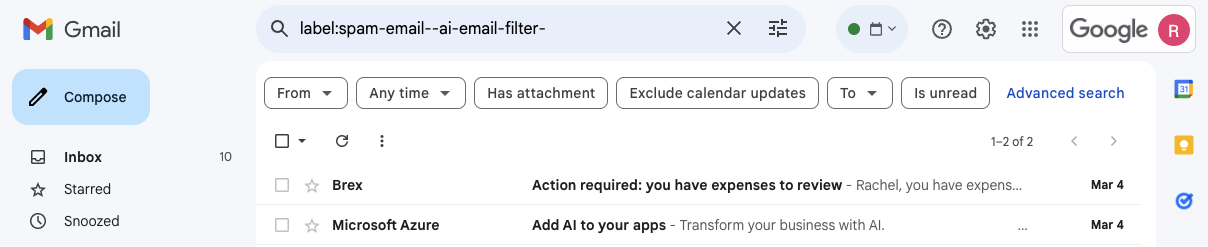

## End of the notebook

Check more Uniflow use cases in the [example folder](https://github.com/CambioML/uniflow/tree/main/example/model#examples)!

<a href="https://www.cambioml.com/" title="Title">
    <img src="../image/cambioml_logo_large.png" style="height: 100px; display: block; margin-left: auto; margin-right: auto;"/>
</a>